In [1]:
%pip install pandas
%pip install scipy
%pip install seaborn
%pip install h5py

import matplotlib.pyplot as plt
import numpy as np

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import yt
import matplotlib.cm as cm
from plot_variables import *
from yt.utilities.math_utils import ortho_find
from helper_functions import *
import datetime
import pandas as pd
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
from scipy.interpolate import interp1d
import matplotlib.image as mpimg
import seaborn as sns

#### Helper functions

In [4]:
def setup_plot_env(fontsize, linewidth):
    rc('font', **{'family': 'serif', 'serif': ['Times'], 'weight': 'light'})
    rc('text', usetex=True)
    plt.rcParams["mathtext.default"] = "regular"
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['lines.linewidth'] = linewidth


def extract_filename_parts(file_paths):
    extracted_parts = []
    for path in file_paths:
        # Extract the base name of the file (e.g., 'data-1B.resim.th.b01-3-eta-0.1.csv')
        base_name = os.path.basename(path)
        # Remove the prefix 'data-' and the file extension '.csv'
        clean_name = base_name.replace('data-', '').rsplit('.', 1)[0]
        extracted_parts.append(clean_name)
    return extracted_parts


# Function to format and create the subplots
def create_subplots(num_subplots, xlim, ylim_mass, time_cutoff, fontsize, title):
    fig, axs = plt.subplots(num_subplots, 1, sharex=True)

    for i in range(num_subplots):
        axs[i].set_xticks(np.arange(0.1, time_cutoff+0.1, 0.1))
        axs[i].minorticks_on()
        axs[i].xaxis.set_minor_locator(plt.MultipleLocator(0.02))
        axs[i].tick_params(axis="x", which='minor', length=2, direction="in")
        axs[i].tick_params(axis="x", which='major', labelsize=fontsize-1, width=1.5, length=3, direction="in")
        axs[i].tick_params(axis="y", which='major', labelsize=fontsize-1)
        axs[i].tick_params(axis="y", which='minor', labelsize=fontsize-2)
        axs[i].set_yscale('log')
        axs[i].set_xlim([0, xlim+0.01]) # for truncated view

    axs[0].set_title(title)
    #axs[0].set_ylim([10.5, ylim_mass+0.01]) # for truncated view 270msun: [240, ylim_mass+0.01]
    axs[0].set_ylabel(r"$\rm M_{BH} \, (M_{\odot})$", fontdict=None)
    axs[1].set_ylabel(r"$\rm \dot{M} \, (M_{\odot}/yr)$", fontdict=None)
    #axs[1].set_ylim([2e-9, 8e-4]) # [2e-9, 8e-4] for 270msun, [5e-9, 6e-2] for 10.8msun-no-SN, [2e-9, 8e-4] for 10.8msun
    axs[-1].set_xlabel('Black Hole Age (Myr)', fontdict=None)

    return fig, axs

def dynamical_timescale_ff(rho):
    # rho in g/cm^3
    return np.sqrt(3*np.pi/(32*6.67e-8*rho))

def dynamical_timescale_vel(v_orb, r):
    # v in cm/s, r in cm
    return 2*np.pi*r/v_orb

def temperature_from_cs(df):
    kb = 1.38e-16 # Boltzmann in erg/K
    mu = 1.3 # mean molecular weight
    gamma = 1.6667
    cs2 = [i*i for i in df['average cinfinity'].dropna().values]
    temp = cs2*mu/(kb*gamma)
    return temp

def sound_crossing_timescale(df, window_size=10, type='jeans'):
    pc_to_km = 3.086e13
    s_to_myr = 1/3.154e13
    scale_df = df['Jeans length'].replace(0, pd.NA).dropna() if type == 'jeans' else df['Bondi radius'].replace(0, pd.NA).dropna()
    cs_df = df['average cinfinity'].replace(0, pd.NA).dropna()
    print(scale_df.shape, cs_df.shape)
    if scale_df.shape != cs_df.shape:
        print('Lengths do not match')
        return
    return (scale_df*pc_to_km/cs_df)*s_to_myr


In [5]:
# Set up plot environment
fontsize = 12
linewidth = 2
alpha = 1
window_size = 100
setup_plot_env(fontsize, linewidth)
num_subplots = 4
#title = '270msun resimulated from 31.7 Myr with thermal feedback'
title = 'Accretion Event 2: 2.50 Myr - 2.80 Myr'

# Load the CSV file into a DataFrame
data_files = [#'data_files/data-1B.RSb04.csv', 
              #'data_files/data-2B.RSb01.csv',
              #'data_files/data-1B.resim.th.b01.csv'
    # 'data_files/data-1B.resim.th.b01-3-eta-0.1.csv',
    # 'data_files/data-1B.resim.th.b01-3-eta-0.01.csv',
    # 'data_files/data-fb-radius=10dx-eta-0.01.csv',
    # 'data_files/data-fb-radius=20dx-eta-0.01.csv',
    # 'data_files/data-1B.resim.th.b01-3-eps-0.001.csv',
    # 'data_files/data-1B.resim.th.b01-3-eps-0.0001.csv',
    # 'data_files/data-1B.RSb01-2.csv'
    'data_files/data-1B.resim.th.b04.csv',
    'data_files/data-1B.resim.th.b04-eta-0.1.csv',
    'data_files/data-1B.resim.th.b04-eps-0.001.csv',
    'data_files/data-1B.resim.th.b04-eta-0.1-2.csv',
    'data_files/data-1B.resim.th.b04-eps-0.001-2.csv',
    # 'data_files/data-1B.RSb01-2.csv',
    # 'data_files/data-1B.th.bf128.csv',
    # 'data_files/data-1B.th.bf128-eps-0.01.csv',
    # 'data_files/data-1B.th.bf128-eps-0.0001.csv',
    ]

# Line colours
c = extract_colors('arbre', int(len(data_files)), start=0.1, end=0.86) # start=0.33, end=0.92 for 10.8msun-no-sn
# Generate a color for each simulation using the colormap
color_map = plt.cm.rainbow
c = color_map(np.linspace(0, 0.95, len(data_files)))
#c= {simulation: color for simulation, color in zip(data_files, colors)}

# Data labels
labels = extract_filename_parts(data_files)
#labels = ['no-fb', r"$\rm \eta=0.1$, $\epsilon=0.05$", r"$\times 0.1$", r"$\times 0.05$", r"$\times 0.005$"]
#labels = ["no-fb", r"$\rm \eta=0.1, \epsilon=0.05$", r"$\epsilon=0.01$", r"$\epsilon=0.0001$"]

# Define rho for the dynamical timescale
rho_index = 1
df = pd.read_csv(data_files[rho_index]).dropna()
rho = df['average density'].values.mean()
t_cs = sound_crossing_timescale(df, window_size, type='bondi')
print(f"density = {rho:.0e}")

# find the dynamical timescale 
mh = 1.6735e-24 # hydrogen mass in g
t_ff = dynamical_timescale_ff(rho*mh)/3.15576e13

(5568,) (5568,)
density = 4e+06


## BH/Gas properties vs Time for Feedback Runs

Saved plot to plots/Accretion_Event_2:_2.50_Myr_-_2.80_Myr_2024-06-24.png


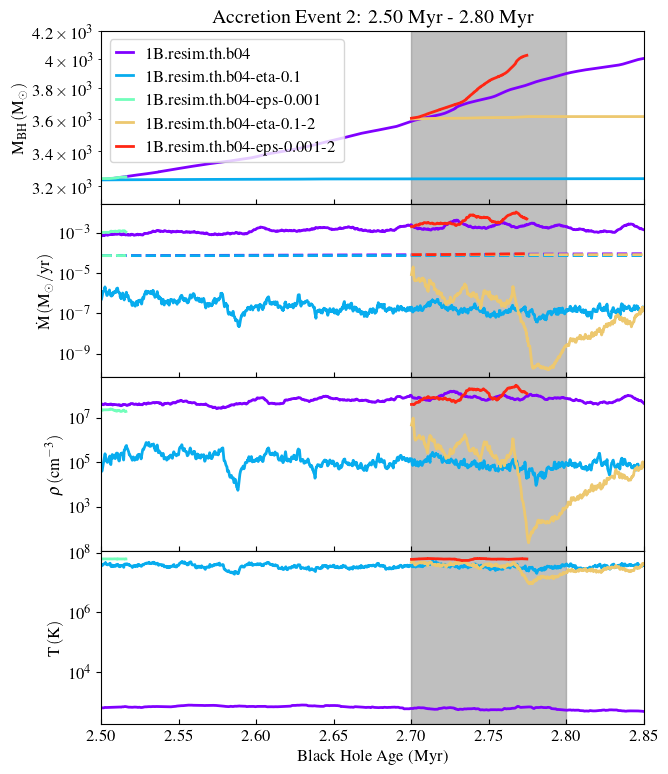

In [6]:

fig, axs = plt.subplots(num_subplots, 1)
window_size = 100
age_units = None # or "t_cs" or None
for j, data_file in enumerate(data_files):

    # Load the CSV file into a DataFrame
    df = pd.read_csv(data_file)

    # Extract the columns you're interested in
    #age = df['age'].values/1e6
    age = (df['age'].values/1e6)/t_cs.mean() if age_units == "t_cs" else (df['age'].values/1e6)/t_ff if age_units == "t_ff" else df['age'].values/1e6
    bh_mass = adaptive_moving_average(df['BH mass'].values, window_size)
    accrate = adaptive_moving_average(df['accrate'].values, window_size)
    density = adaptive_moving_average(df['average density'].values, window_size)
    temperature = adaptive_moving_average(df['temperature'].values, window_size)

    # 1) BH Mass
    axs[0].plot(age, bh_mass, color=c[j], linestyle='solid', label=labels[j], alpha=alpha)

    # 2) Accretion Rates
    axs[1].plot(age, accrate, color=c[j], linestyle='solid', label=labels[j], alpha=alpha)
    axs[1].plot(age, eddington_rate(bh_mass), color=c[j], linestyle='dashed', label=labels[j], alpha=alpha)

    # 3) Density
    axs[2].plot(age, density, color=c[j], linestyle='solid', label=labels[j], alpha=alpha)

    # 3) Temperature
    axs[3].plot(age, temperature, color=c[j], linestyle='solid', label=labels[j], alpha=alpha) #if j != 0 else None


# Force x-axis ticks to appear on all subplots
for i, ax in enumerate(axs):
    ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, direction="in")
    ax.set_xlim([2.50, 2.85]) # set xlim [31.70, 31.95], [2.50, 2.85] for accretion event 2
    ax.set_xticklabels([]) if i < 3 else None

# Add shaded region for 'Accretion Event'
for ax in axs:
    ax.axvspan(2.70, 2.80, color='gray', alpha=0.5)
#axs[0].text(2.75, 0.66*axs[0].get_ylim()[1], 'Accretion Event', horizontalalignment='center', verticalalignment='center')

# Set y-axis limits
axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[2].set_yscale('log')
axs[3].set_yscale('log')
axs[0].set_ylim([3.1e3, 4.2e3]) # 6.02e4, 6.15e4, 2.2e3, 5e3
# axs[2].set_ylim([5e4, 1e7])

# Set labels
axs[0].set_ylabel(r"$\rm M_{BH} \, (M_{\odot})$", fontdict=None)
axs[1].set_ylabel(r"$\rm \dot{M} \, (M_{\odot}/yr)$", fontdict=None)
axs[2].set_ylabel(r"$\rm \rho \, (cm^{-3})$", fontdict=None)
axs[3].set_ylabel(r"$\rm T \, (K)$", fontdict=None)
if age_units == "t_cs":
    axs[-1].set_xlabel(r'$t_{{c_s}} (t_{{c_s}} = {:.0e}$ Myr, line \ {})'.format(t_cs.mean(), rho_index+1), fontdict=None)
elif age_units == "t_ff":
    axs[-1].set_xlabel(r'$t_{{ff}} (\rho = {:.0e}, line \ {})$'.format(rho, rho_index+1), fontdict=None)
else:
    axs[-1].set_xlabel('Black Hole Age (Myr)', fontdict=None)

# legend and title
axs[0].legend(fontsize=fontsize, ncol=1, loc="upper left", handlelength=1) # "lower right" for no-sn
axs[0].set_title(title)
fig.subplots_adjust(wspace=0, hspace=0)
fig.set_size_inches(7, 9)

SAVE = True
if SAVE:
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d")
    figname = title.replace(' ', '_').replace('(', '').replace(')', '') + f"_{timestamp}"
    plt.savefig(f'plots/{figname}.png', dpi=300, bbox_inches='tight')
    print(f"Saved plot to plots/{figname}.png")


$dE_{\text{BH-feed}} = \eta \, \epsilon  \, \dot{m}_{\text{BH}} c^2 dt$
- At fb-radius = 5dx, eps = 0.001 (originally eps = 0.05, so decreasing fb efficiency overall by a x0.02), we see accretion rate increase to super-Eddington.
- Increasing the fb radius x2 from 5dx to 10dx results in eta-0.01 going from sub- to super-Eddington accretion rates. Feedback effect on BH growth is sensitive to injection radius.
- Temperature is also lowered from 10^6 K to 10^4 K.

(32404,) (32404,)
(32404,) (32404,)
(5568,) (5568,)
(5568,) (5568,)
(122,) (122,)
(122,) (122,)
(2235,) (2235,)
(2235,) (2235,)
(858,) (858,)
(858,) (858,)


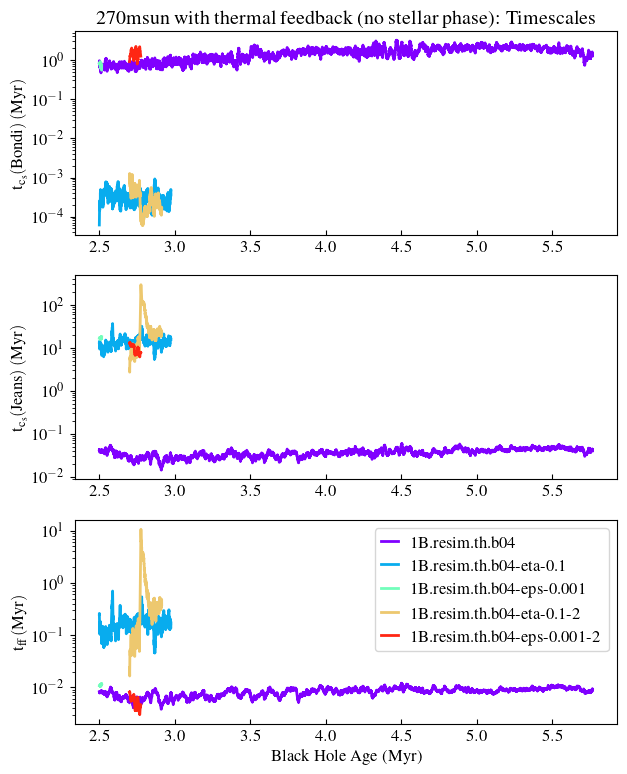

In [7]:
# timescales plot
fig, axs = plt.subplots(3, 1, sharex=True)
window_size = 100
age_units = None # or "t_cs" or None
for j, data_file in enumerate(data_files):

    # Load the CSV file into a DataFrame
    df = pd.read_csv(data_file)

    # sound crossing timescale Bondi
    t_cs = adaptive_moving_average(sound_crossing_timescale(df, window_size, type='bondi'), window_size)

    # # sound crossing timescale Jeans
    t_jeans = adaptive_moving_average(sound_crossing_timescale(df, window_size, type='jeans'), window_size)

    # # find the dynamical timescale 
    mh = 1.6735e-24 # hydrogen mass in g
    density = adaptive_moving_average(df['average density'].values, window_size)
    t_ff = dynamical_timescale_ff(density*mh)/3.15576e13

    # Assuming df['age'].values and t_cs are available and sorted
    x_original = np.linspace(0, 1, len(df['age'].values))  # Normalize original x-axis
    x_new = np.linspace(0, 1, len(t_cs))  # New x-axis for interpolation

    # Create interpolation function
    interp_func = interp1d(x_original, df['age'].values/1e6)

    # Interpolate 'age' to match 't_cs' length
    age_interpolated = interp_func(x_new)

    # plot the timescales
    axs[0].plot(adaptive_moving_average(age_interpolated, int(len(df['age'].values)/len(t_cs))), t_cs, color=c[j], linestyle='solid', label=labels[j], alpha=alpha)
    axs[1].plot(adaptive_moving_average(age_interpolated, int(len(df['age'].values)/len(t_jeans))), t_jeans, color=c[j], linestyle='solid', label=labels[j], alpha=alpha)
    axs[2].plot(df['age'].values/1e6, t_ff, color=c[j], linestyle='solid', label=labels[j], alpha=alpha)

# Force x-axis ticks to appear on all subplots
for i, ax in enumerate(axs):
    ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, direction="in")
    if i != (num_subplots - 1): ax.set_label('')

# Set labels
for i in range(3):
    axs[i].set_yscale('log')

# set axes labels
axs[0].set_ylabel(r"$\rm t_{c_s} (Bondi) \, (Myr)$", fontdict=None)
axs[1].set_ylabel(r"$\rm t_{c_s} (Jeans) \, (Myr)$", fontdict=None)
axs[2].set_ylabel(r"$\rm t_{ff} \, (Myr)$", fontdict=None)
axs[-1].legend(fontsize=fontsize, ncol=1, loc="upper right", handlelength=1) 
axs[-1].set_xlabel('Black Hole Age (Myr)', fontdict=None)


# Set axes limits
#axs[0].set_ylim([2e-5, 2])
#axs[-1].set_xlim([31.70, 31.95]) # for truncated view
#axs[-1].set_xlim([0, 1.4])
#axs[1].set_ylim([2e-6, 2e-1]) # 
axs[0].set_title('270msun with thermal feedback (no stellar phase): Timescales')
fig.set_size_inches(7, 9)


# Making (1, 3) panel

In [8]:
def extract_parts(fp):
    # Define the regex pattern to capture the desired parts
    # This pattern looks for a string between the second and third underscore
    # and a DD0 followed by digits
    pattern = r'.*?_([^_]+)_(DD0\d+)_.*'

    # Search using the pattern
    match = re.search(pattern, fp)
    
    # If a match is found, return the captured groups; otherwise return None for both
    if match:
        part1, part2 = match.groups()
        return part1, part2
    else:
        return None, None
    


def make_3_panel_plot(image_paths):
    # Extract the simulation and DD number from the first image path
    sim, dd = extract_parts(image_paths[0]) 

    # Create a figure and a set of subplots
    fig, axs = plt.subplots(1, 3, figsize=(10, 3.333))

    # Loop through the image paths and axs to display each image
    for ax, image_path in zip(axs, image_paths):
        img = mpimg.imread(image_path)  # Load the image
        ax.imshow(img)  # Display the image
        ax.axis('off')  # Turn off axis
    # Manually adjust the positions of the first two subplots to make them overlap
    # ax.set_position([left, bottom, width, height]) where the values are fraction of figure width and height
    axs[0].set_position([0.0, 0.1, 0.4, 0.8])  # Example position for the first subplot
    axs[1].set_position([0.265, 0.1, 0.4, 0.8])  # Adjust so the second subplot overlaps the first
    axs[2].set_position([0.265*2, 0.1, 0.4, 0.8])
    axs[1].set_title('Clumps in {sim} at {dd}'.format(sim=sim, dd=dd))  # Add a title to the figure
    plt.savefig(f'clump_projection_{sim}_{dd}_grav_bound_combined.png')  # Save the combined image to a file
    plt.show()  # Display the figure
    #print(f'Combined image saved as clump_projection_{sim}_{dd}_grav_bound_combined.png')  # Print a message to the console


# 1B.b01

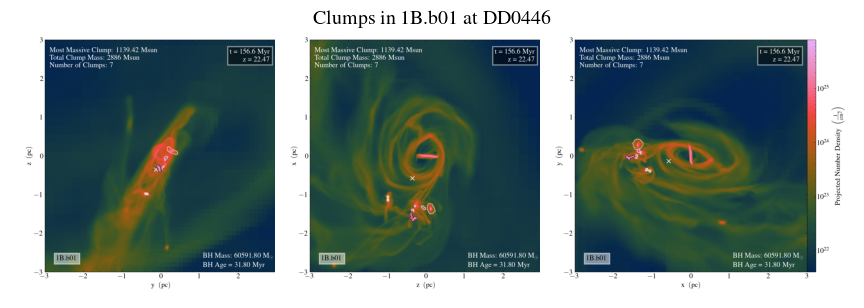

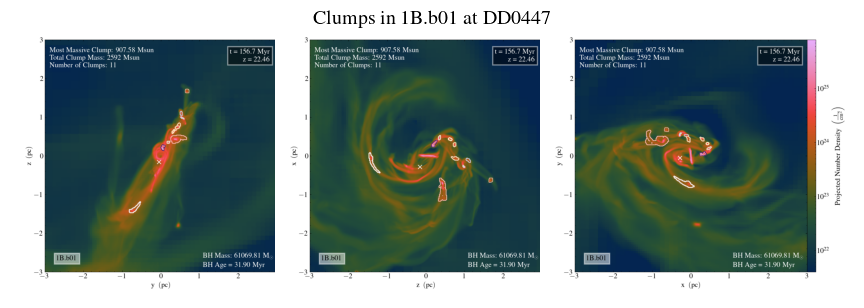

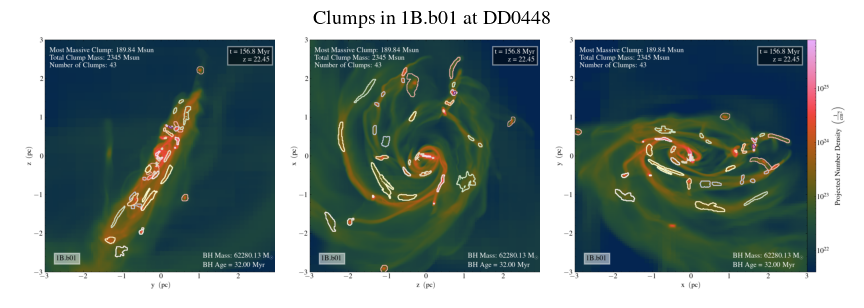

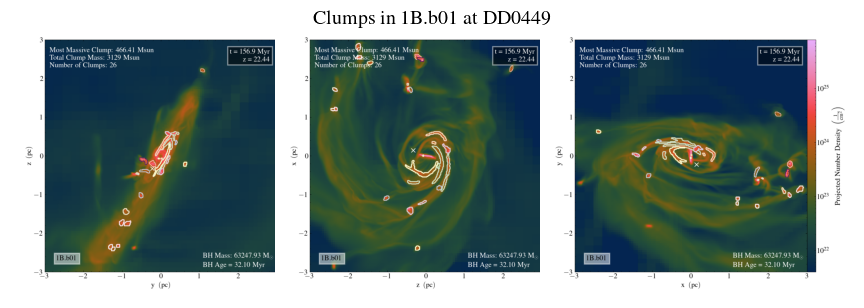

In [9]:
# Paths to your PNG images
image_paths_1 = ['../plots/clump_projection_1B.b01_DD0446_0_8.70e+05_grav_bound.png', 
               '../plots/clump_projection_1B.b01_DD0446_1_8.70e+05_grav_bound.png', 
               '../plots/clump_projection_1B.b01_DD0446_2_8.70e+05_grav_bound.png']
image_paths_2 = ['../plots/clump_projection_1B.b01_DD0447_0_7.51e+05_grav_bound.png', 
               '../plots/clump_projection_1B.b01_DD0447_1_7.51e+05_grav_bound.png', 
               '../plots/clump_projection_1B.b01_DD0447_2_7.51e+05_grav_bound.png']
image_paths_3 = ['../plots/clump_projection_1B.b01_DD0448_0_1.05e+05.png', 
               '../plots/clump_projection_1B.b01_DD0448_1_1.05e+05.png', 
               '../plots/clump_projection_1B.b01_DD0448_2_1.05e+05.png']
image_paths_4 = ['../plots/clump_projection_1B.b01_DD0449_0_1.28e+06.png',
                 '../plots/clump_projection_1B.b01_DD0449_1_1.28e+06.png',
                 '../plots/clump_projection_1B.b01_DD0449_2_1.28e+06.png']
make_3_panel_plot(image_paths_1)
make_3_panel_plot(image_paths_2)
make_3_panel_plot(image_paths_3)
make_3_panel_plot(image_paths_4)

# 1B.resim.th.b01-3-eps-0.0001

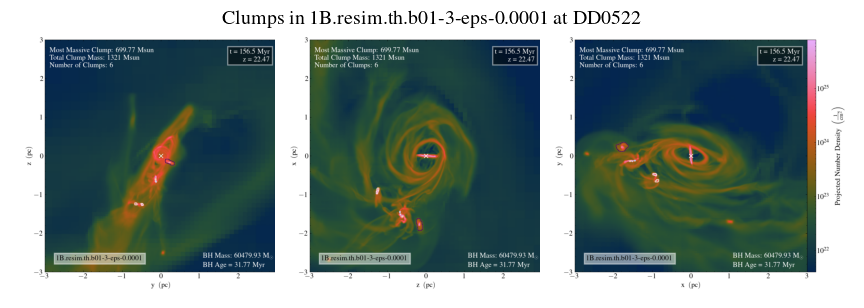

In [16]:
# BH Age = 31.77 Myr
image_paths_1 = ['../plots/clump_projection_1B.resim.th.b01-3-eps-0.0001_DD0522_0_1.00e+06_grav_bound.png',
                    '../plots/clump_projection_1B.resim.th.b01-3-eps-0.0001_DD0522_1_1.00e+06_grav_bound.png',
                    '../plots/clump_projection_1B.resim.th.b01-3-eps-0.0001_DD0522_2_1.00e+06_grav_bound.png']
make_3_panel_plot(image_paths_1)

# 1B.resim.th.b01-3-eps-0.001

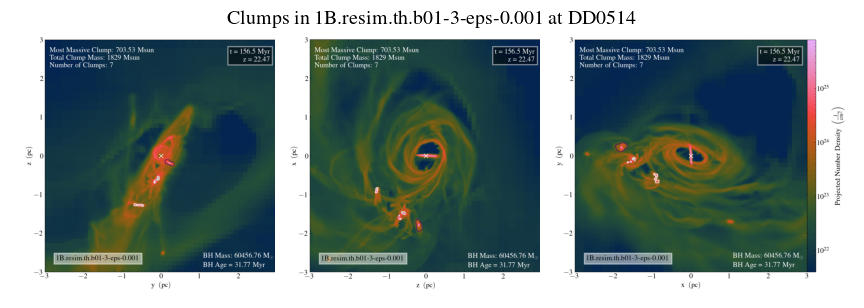

In [17]:
image_paths_2 = ['../plots/clump_projection_1B.resim.th.b01-3-eps-0.001_DD0514_0_1.00e+06_grav_bound.png',
                    '../plots/clump_projection_1B.resim.th.b01-3-eps-0.001_DD0514_1_1.00e+06_grav_bound.png',
                    '../plots/clump_projection_1B.resim.th.b01-3-eps-0.001_DD0514_2_1.00e+06_grav_bound.png']
make_3_panel_plot(image_paths_2)

# 1B.resim.th.b01-3-eta-0.01

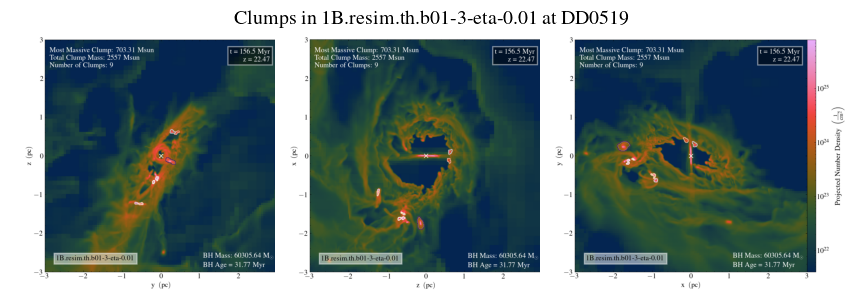

In [18]:
image_paths_3 = ['../plots/clump_projection_1B.resim.th.b01-3-eta-0.01_DD0519_0_1.00e+06_grav_bound.png',
                    '../plots/clump_projection_1B.resim.th.b01-3-eta-0.01_DD0519_1_1.00e+06_grav_bound.png',
                    '../plots/clump_projection_1B.resim.th.b01-3-eta-0.01_DD0519_2_1.00e+06_grav_bound.png']

make_3_panel_plot(image_paths_3)

# 1B.resim.th.b01-3-eta-0.1

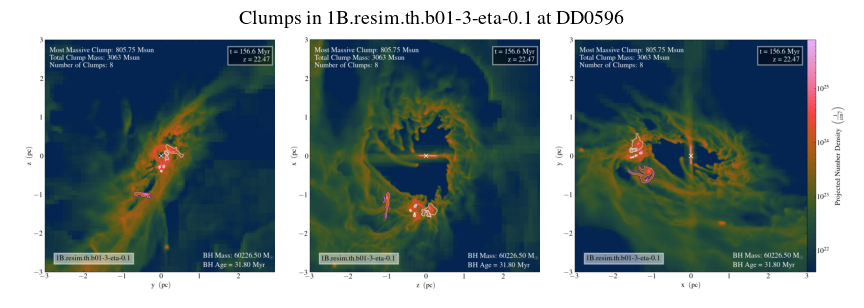

In [19]:
# image_paths_4 = ['../plots/clump_projection_1B.resim.th.b01-3-eta-0.1_DD0596_0_1.37e+03_grav_bound.png',
#                 '../plots/clump_projection_1B.resim.th.b01-3-eta-0.1_DD0596_1_1.37e+03_grav_bound.png',
#                 '../plots/clump_projection_1B.resim.th.b01-3-eta-0.1_DD0596_2_1.37e+03_grav_bound.png']
image_paths_4 = ['../plots/clump_projection_1B.resim.th.b01-3-eta-0.1_DD0596_0_1.00e+06_grav_bound.png',
                 '../plots/clump_projection_1B.resim.th.b01-3-eta-0.1_DD0596_1_1.00e+06_grav_bound.png',
                '../plots/clump_projection_1B.resim.th.b01-3-eta-0.1_DD0596_2_1.00e+06_grav_bound.png']

make_3_panel_plot(image_paths_4)

# Analysing Clumps

Unique simulations before filtering: ['1B.resim.th.b04' '1B.RSb01-2' '1B.resim.th.b01-3-eta-0.01'
 'fb-radius=10dx' 'fb-radius=20dx' '1B.resim.th.b01-3-eta-0.1'
 '1B.resim.th.b01-3-eps-0.0001' '1B.resim.th.b01-3-eps-0.001'
 '2B.resim.th.b01-eps-0.001' '2B.resim.th.b01-eta-0.1-2'
 '2B.resim.th.b01-eps-0.001-2' '2B.resim.th.b01-eps-0.01'
 '2B.resim.th.b01']
Unique simulations after filtering: ['1B.RSb01-2' '1B.resim.th.b01-3-eta-0.01' '1B.resim.th.b01-3-eta-0.1'
 '1B.resim.th.b01-3-eps-0.0001' '1B.resim.th.b01-3-eps-0.001']
Saved plot to plots/clump_properties_over_time_1B.resim.th.b01-3-eta-0.01_min-density=598_2024-06-24-07-21.png


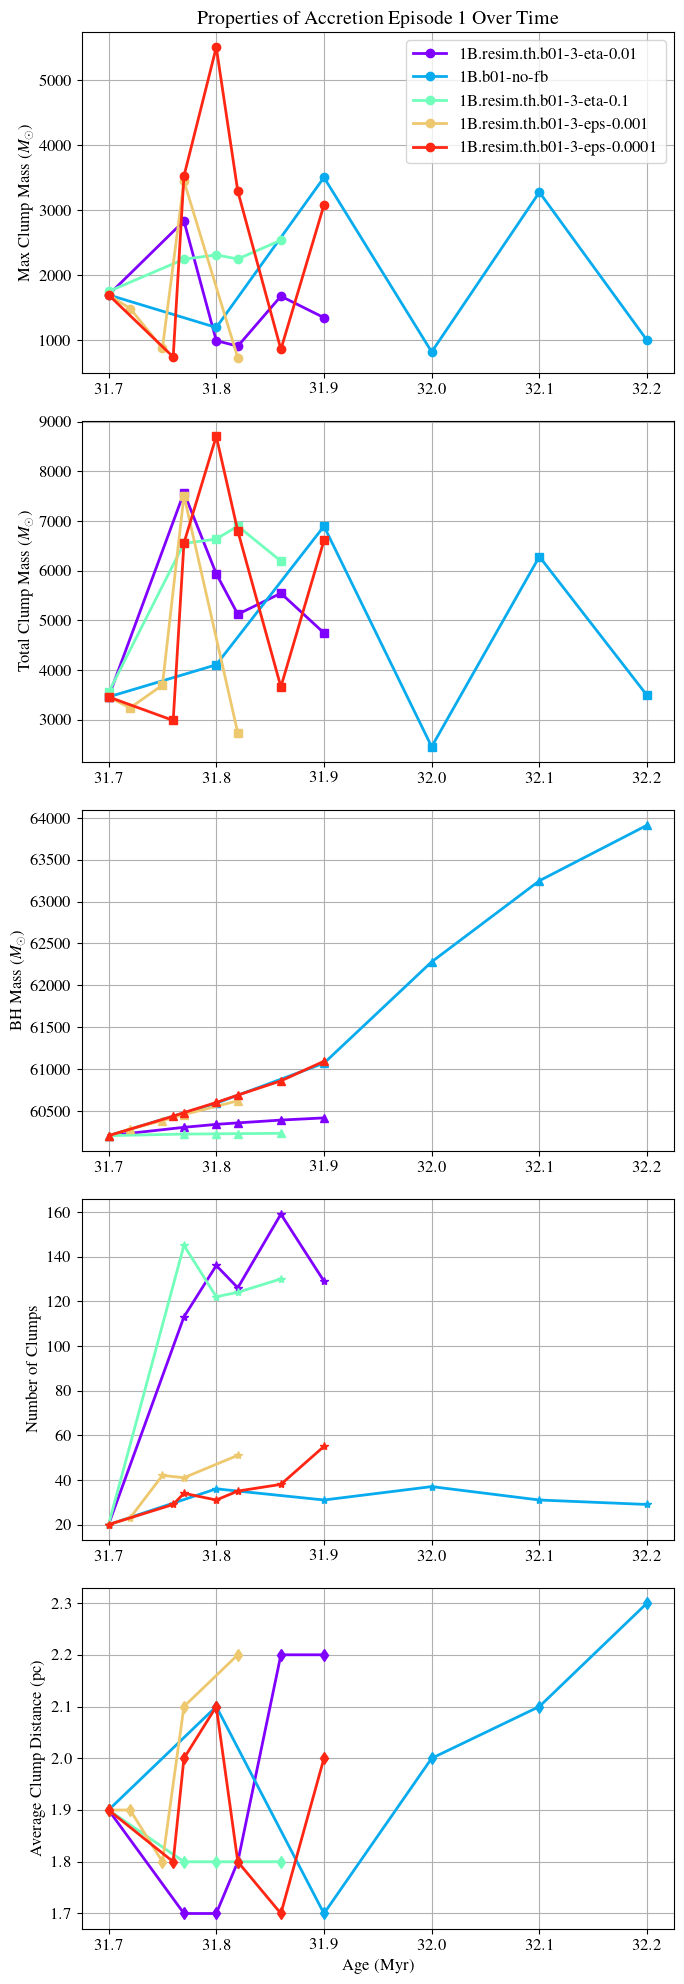

In [8]:
# Load the data from the CSV file
df = pd.read_csv('clump_data.csv', comment='#')

# Apply filters to dataframe
df['future_bound'] = df['future_bound'].map({' True': True, ' False': False})
df = df.round({'age_myr': 2, 'max_clump_mass': 1, 'total_clump_mass': 1, 'bh_mass': 1, 'no_clumps': 0, 'average_clump_distance': 1})
min_density = 597.5500448162534
filt = df[df['min_density'] == str(min_density)]

# Inspect unique values in 'simulation' column
print("Unique simulations before filtering:", filt['simulation'].unique())

# User-specified prefix for filtering simulations
prefix1 = "1B.resim.th.b01-3" #"2B.resim.th.b01"  # Replace with the desired prefix
prefix2 = "1B.RSb01"

# Filter the DataFrame based on the prefix
filt = filt[filt['simulation'].str.startswith(prefix1.strip()) | filt['simulation'].str.startswith(prefix2.strip())]

# Inspect unique values in 'simulation' column after filtering
print("Unique simulations after filtering:", filt['simulation'].unique())

# Check if the filtered DataFrame is empty
if filt.empty:
    print("The filtered DataFrame is empty. Please check the prefix and data.")
else:
    # Sort the DataFrame by 'age_myr' to ensure the plots are in chronological order
    filt = filt.sort_values('age_myr')

    # Unique simulations and BH Age values for grouping
    filt['simulation'] = filt['simulation'].replace("1B.RSb01-2", "1B.b01-no-fb")
    simulations = filt['simulation'].unique()

    # Ensure that the custom order includes all simulations (optional, remove if not needed)
    custom_order = False
    # custom_order = [
    #     '2B.resim.th.b01', '2B.resim.th.b01-eps-0.01', '2B.resim.th.b01-eps-0.001', 
    #     '2B.resim.th.b01-eps-0.001-2', '2B.resim.th.b01-eta-0.1-2'
    # ]

    # Ensure that the custom order includes all simulations (remove if not needed)
    if custom_order and set(custom_order) != set(simulations):
        raise ValueError("Custom order must include all simulations")

    simulations = custom_order if custom_order else simulations
    ages = filt['age_myr'].unique()
    properties = ["max_clump_mass", "total_clump_mass", "bh_mass", "no_clumps", "average_clump_distance"]

    # Generate a color for each simulation using the colormap
    color_map = plt.cm.rainbow
    colors = color_map(np.linspace(0, 0.95, len(simulations)))
    simulation_colors = {simulation: color for simulation, color in zip(simulations, colors)}

    # Create subplots - one for each property
    fig, axs = plt.subplots(len(properties), 1, figsize=(7, 4 * len(properties)))

    # Create a dictionary to store whether the legend label has been added for each simulation
    added_legend = {simulation: False for simulation in simulations}

    # Iterate over properties to create each subplot
    for i, property in enumerate(properties):
        # Iterate over simulations
        for simulation in simulations:
            # Filter the data for each simulation
            data = filt[filt['simulation'] == simulation]
            # Get the color for the current simulation
            color = simulation_colors[simulation]
            # Check if there is data to plot
            if not data.empty:
                # Plot the data for the current simulation with markers and lines
                marker = 'o' if i == 0 else 's' if i == 1 else '^' if i == 2 else '*' if i == 3 else 'd'
                axs[i].plot(data['age_myr'], data[property], marker=marker, linestyle='-', color=color, label=simulation if not added_legend[simulation] else "_nolegend_")
                # Add the simulation to the legend only if it hasn't been added before
                if not added_legend[simulation]:
                    added_legend[simulation] = True

    # Plot max_clump_mass over age_myr
    axs[0].set_ylabel('Max Clump Mass ($M_\odot$)')
    axs[0].set_title('Properties of Accretion Episode 1 Over Time')
    axs[0].legend()

    # Plot total_clump_mass over age_myr
    axs[1].set_ylabel('Total Clump Mass ($M_\odot$)')

    # Plot bh_mass over age_myr
    axs[2].set_ylabel('BH Mass ($M_\odot$)')

    # Plot no_clumps over age_myr
    axs[3].set_ylabel('Number of Clumps')

    # Plot average_clump_distance over age_myr
    axs[4].set_ylabel('Average Clump Distance (pc)')
    axs[4].set_xlabel('Age (Myr)')

    # Optional: Add grid to each subplot for better readability
    for ax in axs:
        ax.grid(True)

    plt.tight_layout()
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")
    figtitle = 'clump_properties_over_time' + f"_{simulations[0]}" + f"_min-density={min_density:.0f}" + f"_{timestamp}"
    plt.savefig(f'plots/{figtitle}.png', dpi=300, bbox_inches='tight')
    print(f"Saved plot to plots/{figtitle}.png")


The default fb-radius is 5dx. Increased here to 10dx and 20dx for eta=0.01. In physical units: dx = 0.0143 pc, 5dx = 0.07 pc, 10dx = 0.14 pc, 20dx = 0.28 pc.
Reduced the impact of feedback on the mass growth and number of clumps.

The 5dx was originally chosen as its well within the high-resolution feedback zone 11dx^3. 10dx is also within this, and it has an appreciable effect on the BH growth and clump statistics.

The no-feedback accretion period is characterised by a steep increase in BH mass between 31.90 and 32.00 (maybe 32.10, need to plot). During this period, there is a reduction in the total clump mass, max clump mass, but little change in the total number of clumps.

Total clump mass by age:
   age_myr  total_clump_mass
0     6.90            1514.5
1     6.93            1112.0
2     6.95             547.0
3     6.98             799.5
4     7.00             663.5
5     7.03             797.5
6     7.05            1464.0
Successfully merged total_clump_mass into filt_data
Filtered data with total clump mass (sorted by age_myr):
   age_myr  total_clump_mass
6     6.90            1514.5
4     6.93            1112.0
2     6.95             547.0
3     6.98             799.5
5     7.00             663.5
1     7.03             797.5
0     7.05            1464.0
Ages (xticks) for total clump mass:
[6.9  6.93 6.95 6.98 7.   7.03 7.05]
Total clump masses for ticks:
[1514.5 1112.   547.   799.5  663.5  797.5 1464. ]
Saved plot to plots/clump_mass_vs_distance_2B.resim.th.b01-eps-0.001-2_clump_mass_bin_Age (Myr)_Clump Distance (pc)_BH Mass ($M_\odot$)_max_dist_1.png


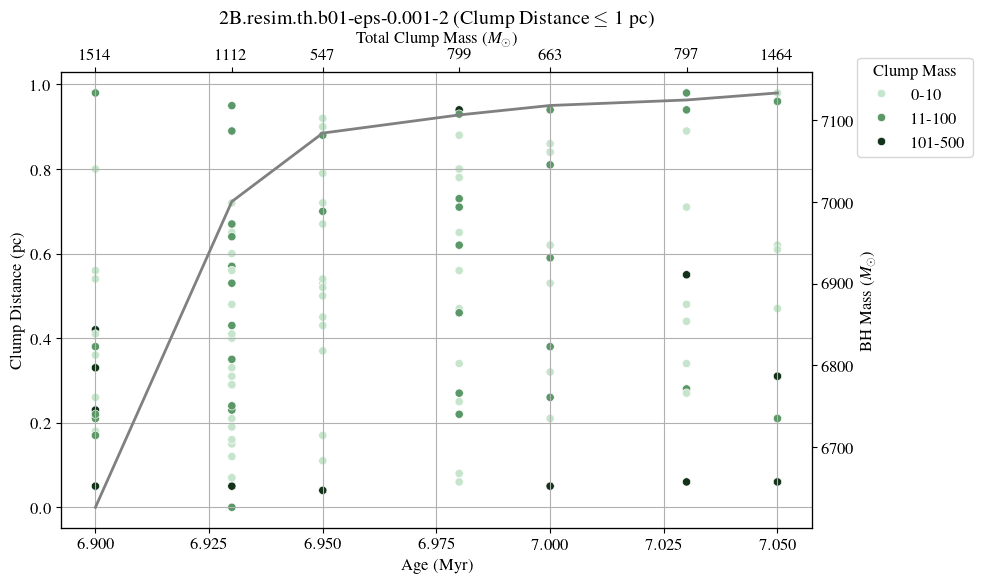

In [90]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# User-set parameters
filter_method = "complete_name"  # Choose "prefix" or "complete_name"
simulation_name = "2B.resim.th.b01-eps-0.001-2"  # Replace with the desired complete name
prefix = "2B.resim.th.b01"  # Replace with the desired prefix if using prefix filtering
num_bins = 3
palette = sns.color_palette("ch:s=2,r=0", num_bins)  # You can also use "dark", "colorblind", or any other seaborn palette
max_clump_distance = 1  # Replace with the desired maximum clump distance

# Load the data from the CSV files
df_clump_distances = pd.read_csv('clump_distances.csv')
df_clump_data = pd.read_csv('clump_data.csv')

# Custom binning function for clump_mass
def bin_clump_mass(value):
    if value <= 10:
        return '0-10'
    elif value <= 100:
        return '11-100'
    elif value <= 500:
        return '101-500'
    elif value <= 1000:
        return '501-1000'
    elif value <= 2000:
        return '1001-2000'
    else:
        return '2000+'

# Apply custom binning
df_clump_distances['clump_mass_bin'] = df_clump_distances['clump_mass'].apply(bin_clump_mass)
df_clump_distances = df_clump_distances.round({'age_myr': 2, 'clump_distance': 2})

# Remove rows with NaN values in the 'simulation' column
df_clump_distances = df_clump_distances.dropna(subset=['simulation'])
df_clump_data = df_clump_data.dropna(subset=['simulation'])

# Ensure age_myr columns are of the same type and precision
df_clump_distances['age_myr'] = df_clump_distances['age_myr'].astype(float).round(2)
df_clump_data['age_myr'] = df_clump_data['age_myr'].astype(float).round(2)

# Filter the DataFrame based on the chosen method
if filter_method == "prefix":
    filt_distances = df_clump_distances[df_clump_distances['simulation'].str.startswith(prefix.strip())]
    filt_data = df_clump_data[df_clump_data['simulation'].str.startswith(prefix.strip())]
elif filter_method == "complete_name":
    filt_distances = df_clump_distances[df_clump_distances['simulation'] == simulation_name]
    filt_data = df_clump_data[df_clump_data['simulation'] == simulation_name]
    prefix = simulation_name

# Filter clumps based on the specified maximum distance
filt_distances = filt_distances[filt_distances['clump_distance'] <= max_clump_distance]

# Calculate the total clump mass for each age bin within the maximum clump distance
def calculate_clump_mass(bin_label):
    if '+' in bin_label:
        return int(bin_label.split('-')[1].replace('+', ''))
    else:
        return sum(map(int, bin_label.split('-'))) / 2

# Apply the custom clump mass calculation to each row
filt_distances['clump_mass_value'] = filt_distances['clump_mass_bin'].map(calculate_clump_mass)

# Aggregate total clump mass by age
total_clump_mass = filt_distances.groupby('age_myr')['clump_mass_value'].sum().reset_index()
total_clump_mass.columns = ['age_myr', 'total_clump_mass']

# Debug print statements
print("Total clump mass by age:")
print(total_clump_mass)

# Merge the total clump mass into the filt_data DataFrame
merged_data = pd.merge(filt_data, total_clump_mass, on='age_myr', how='left')

# Replace filt_data with merged_data and clean up columns
filt_data = merged_data.drop(columns=['total_clump_mass_x']).rename(columns={'total_clump_mass_y': 'total_clump_mass'})

# Sort filt_data by age_myr in ascending order
filt_data = filt_data.sort_values(by='age_myr')

# Remove the last row in filt_data
filt_data = filt_data.drop(filt_data.index[-1])

# Check if 'total_clump_mass' column is in the DataFrame
if 'total_clump_mass' in filt_data.columns:
    print("Successfully merged total_clump_mass into filt_data")
else:
    print("Failed to merge total_clump_mass into filt_data")

# Debug print statements
print("Filtered data with total clump mass (sorted by age_myr):")
print(filt_data[['age_myr', 'total_clump_mass']])

# Define the order of the bins and adjust according to num_bins
bin_order = ['0-10', '11-100', '101-500', '501-1000', '1001-2000', '2000+'][:num_bins]

# Plot Clump Mass vs. Clump Distance with secondary y-axis for BH Mass
fig, ax1 = plt.subplots(figsize=(10, 6))

try:
    # Primary y-axis for Clump Distance
    hue = 'clump_mass_bin'
    sns.scatterplot(data=filt_distances, x='age_myr', y='clump_distance', hue=hue, hue_order=bin_order, palette=palette, alpha=1, ax=ax1)
    ax1.set_xlabel('Age (Myr)')
    ax1.set_ylabel('Clump Distance (pc)')
    ax1.set_title(f'{prefix} (Clump Distance $\leq$ {max_clump_distance} pc)')
    ax1.grid(True)

    # Secondary y-axis for BH Mass
    ax2 = ax1.twinx()
    sns.lineplot(data=filt_data, x='age_myr', y='bh_mass', color='grey', ax=ax2)
    ax2.set_ylabel('BH Mass ($M_\odot$)')

    # Adding top x-axis for Total Clump Mass
    ax3 = ax1.twiny()
    ax3.set_xlim(ax1.get_xlim())  # Ensure ax3 aligns with ax1

    # Limit the number of ticks on the x-axis
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=8))

    # Directly use the ages and total clump masses for ticks
    xticks = filt_data['age_myr'].values
    total_clump_masses = filt_data['total_clump_mass'].values

    # Debug print statements
    print("Ages (xticks) for total clump mass:")
    print(xticks)
    print("Total clump masses for ticks:")
    print(total_clump_masses)

    # Create a secondary x-axis that shares the x-axis with ax1
    ax3.set_xticks(xticks)
    ax3.set_xticklabels(total_clump_masses.astype(int))

    # Set the x-axis label for the secondary x-axis
    ax3.set_xlabel('Total Clump Mass ($M_\odot$)')

    # Legend and layout adjustments
    ax1.legend(title='Clump Mass', bbox_to_anchor=(1.05, 1.05), loc='upper left')
    fig.tight_layout()

    # Retrieve and print axis labels
    x_label = ax1.get_xlabel()
    y_label_left = ax1.get_ylabel()
    y_label_right = ax2.get_ylabel()

    # Save the figure
    figname = f'plots/clump_mass_vs_distance_{prefix}_{hue}_{x_label}_{y_label_left}_{y_label_right}_max_dist_{max_clump_distance}.png'
    plt.savefig(figname, dpi=300)
    print(f"Saved plot to {figname}")
    plt.show()
except Exception as e:
    print(f"An error occurred: {e}")


In [81]:
filt_data['age_myr'], xticks = [filt_data['age_myr'], ax1.get_xticks()]

In [82]:

total_clump_mass_interpolated = np.interp(xticks, filt_data['age_myr'], filt_data['total_clump_mass'])
total_clump_mass_interpolated, np.array(filt_data['total_clump_mass'])

(array([1514.5       , 1514.5       , 1179.08333333,  547.        ,
         757.41666667,  663.5       ,  775.16666667, 1464.        ,
        1464.        ]),
 array([1514.5, 1112. ,  547. ,  799.5,  663.5,  797.5, 1464. ]))

- put total mass in clumps on top x-axis. maybe cut at some distance - filtering the clumps.
- inspect movie for cause of events in first place
- run more sims with resolution: more fragments at high res?
- early on simulation with no-clump, resimulate from accretion event start at higher res. 4th accretion event.
- 1B.resimu.th04 - compare with 01 at same time - how much weaker is the accretion event?

# Residual Density Sliceplot

In [71]:
# Load the datasets
ds_og = yt.load("/Backup01/sgordon/disk14/pleiades-11-12-23/seed1-bh-only/270msun/replicating-beckmann/1B.RSb01-2/DD0445/DD0445")
ds_no_feedback = yt.load("/Backup01/sgordon/disk14/pleiades-11-12-23/seed1-bh-only/270msun/replicating-beckmann/1B.RSb01-2/DD0447/DD0447")
ds_with_feedback = yt.load("/disk01/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b01-3-eta-0.1/DD0695/DD0695")
ss_pos_no_fb, ss_mass, ss_age = ss_properties(ds_no_feedback)
ss_pos_fb, _, ss_age_fb = ss_properties(ds_with_feedback)
ss_pos_og, _, ss_age_og = ss_properties(ds_og)


yt : [INFO     ] 2024-06-20 12:51:35,825 Parameters: current_time              = 17.475156649306
yt : [INFO     ] 2024-06-20 12:51:35,826 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-06-20 12:51:35,828 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-06-20 12:51:35,828 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-06-20 12:51:35,829 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-06-20 12:51:35,830 Parameters: current_redshift          = 22.479904727113
yt : [INFO     ] 2024-06-20 12:51:35,831 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-06-20 12:51:35,832 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-06-20 12:51:35,832 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-06-20 12:51:35,833 Parameters: hubble_constant           = 0.71
yt : [INFO     ] 2024-06-20 12:51:35,902 Parameters: current_time              = 17.497494729306
yt :

ds =  DD0447


Parsing Hierarchy : 100%|██████████| 3826/3826 [00:00<00:00, 8496.79it/s]
yt : [INFO     ] 2024-06-20 12:51:36,517 Gathering a field list (this may take a moment.)


ds =  DD0695


Parsing Hierarchy : 100%|██████████| 5465/5465 [00:00<00:00, 9827.63it/s] 


ds =  DD0445


Parsing Hierarchy : 100%|██████████| 4002/4002 [00:00<00:00, 18668.68it/s]


In [72]:
_, _, ss_age = ss_properties(ds_with_feedback)
ss_age_fb = ss_age

ds =  DD0695


In [73]:
global CONTRAST
CONTRAST = False

# Define the size of the region to visualize and the resolution of the FRB
width = (7.0, 'pc')  # Width of the region in physical units
resolution = (1000, 1000)  # Resolution of the FRB

# Load clump datasets (assuming these are the paths to your clump data files)
clumps_no_feedback = yt.load('../clumps/DD0447_clump_0.h5')
clumps_with_feedback = yt.load('../clumps/DD0695_clump_0.h5')
clumps_og = yt.load('../clumps/DD0445_clump_0.h5')

# Clump position (proper pc)
clumps_pos_no_fb = [clump["clump", "position"].to('pc') for clump in clumps_no_feedback.leaves]
clumps_pos_with_fb = [clump["clump", "position"].to('pc') for clump in clumps_with_feedback.leaves]
clumps_pos_og = [clump["clump", "position"].to('pc') for clump in clumps_og.leaves]

# Extract the position of the clumps relative to the BH
clumps_pos_rel_no_fb = np.array([pos - ss_pos_no_fb.to('pc') for pos in clumps_pos_no_fb])
clumps_pos_rel_with_fb = np.array([pos - ss_pos_fb.to('pc') for pos in clumps_pos_with_fb])
clumps_pos_rel_og = np.array([pos - ss_pos_og.to('pc') for pos in clumps_pos_og])


# Find position of most massive clump
pos_max_clump_no_fb = clumps_pos_no_fb[np.argmax([clump["clump", "cell_mass"].to('Msun') for clump in clumps_no_feedback.leaves])]
pos_max_clump_with_fb = clumps_pos_with_fb[np.argmax([clump["clump", "cell_mass"].to('Msun') for clump in clumps_with_feedback.leaves])]

yt : [INFO     ] 2024-06-20 12:52:32,124 Parameters: current_time              = 17.497494729306 code_time
yt : [INFO     ] 2024-06-20 12:52:32,125 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-06-20 12:52:32,126 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-06-20 12:52:32,127 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-06-20 12:52:32,128 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-06-20 12:52:32,129 Parameters: current_redshift          = 22.459915411172
yt : [INFO     ] 2024-06-20 12:52:32,130 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-06-20 12:52:32,130 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-06-20 12:52:32,131 Parameters: hubble_constant           = 0.71
yt : [WARNING  ] 2024-06-20 12:52:32,132 Geometric data selection not available for this dataset type.
yt : [INFO     ] 2024-06-20 12:52:32,506 Parame

In [74]:
# Create slices at the z-coordinate of the most massive clump in the no-feedback and with-feedback datasets
slice_no_feedback = ds_no_feedback.slice('z', pos_max_clump_no_fb[2])
slice_with_feedback = ds_with_feedback.slice('z', pos_max_clump_no_fb[2])

# Create FRBs of the slices centred on the BH position
frb_no_feedback = slice_no_feedback.to_frb(width, resolution, center=ss_pos_no_fb)
frb_with_feedback = slice_with_feedback.to_frb(width, resolution, center=ss_pos_no_fb)

In [75]:
# Calculate the residual density using FRBs
residual_density = np.array(frb_with_feedback['gas', 'density']) - np.array(frb_no_feedback['gas', 'density'])
#residual_density = np.array(frb_with_feedback['gas', 'density'])
residual_density.max(), residual_density.min()

yt : [INFO     ] 2024-06-20 12:52:41,103 Making a fixed resolution buffer of (('gas', 'density')) 1000 by 1000


(3.3375273626823443e-17, -1.1791056581256933e-16)

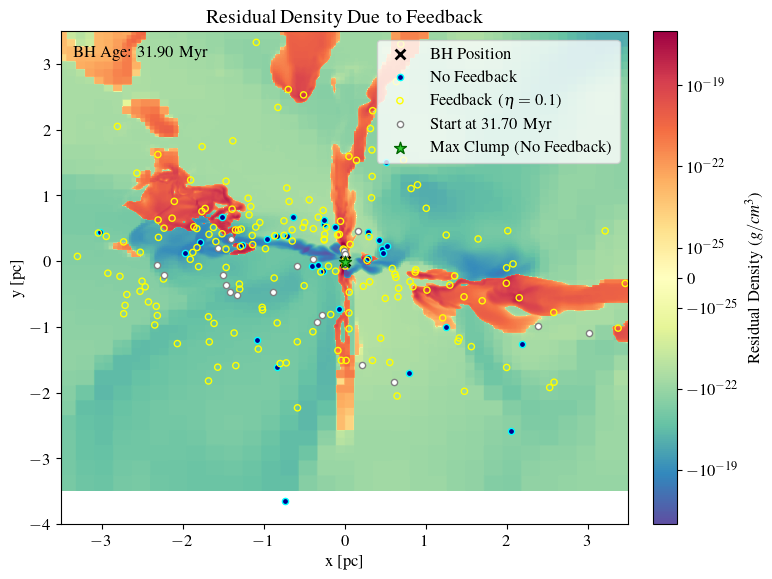

In [42]:
#Plotting the residual density FRB
plt.figure(figsize=(8, 6.4))

extent = [-width[0]/2, width[0]/2, -width[0]/2, width[0]/2]  # Centering the plot around ss_pos

# Select a random clump position as the new center for the plot
np.random.seed(42)  # For reproducibility, optional
random_clump_index = np.random.randint(0, len(clumps_pos_rel_no_fb))
random_clump_pos = clumps_pos_rel_no_fb[random_clump_index]

# Define the size of the region to visualize around the selected clump
width_clump = (1.0, 'pc')  # Smaller width for zooming in
resolution_clump = (1000, 1000)  # Resolution of the FRB, adjust as needed

# Calculate the extent around this clump
extent_clump = [
    random_clump_pos[0] - width_clump[0]/2, random_clump_pos[0] + width_clump[0]/2,
    random_clump_pos[1] - width_clump[0]/2, random_clump_pos[1] + width_clump[0]/2
]

# Set the norm to LogNorm to apply a logarithmic scale
# Adjust vmin and vmax as needed; these should be > 0 for log scale
vmin, vmax, linthresh = -1e-17, 1e-17, 1e-25
im = plt.imshow(
    residual_density if not CONTRAST else density_contrast,
    extent=extent, # Change extent to zoom in on the clump
    origin='lower',
    aspect='auto',
    cmap='Spectral_r',
    norm=SymLogNorm(linthresh=linthresh, vmin=vmin, vmax=vmax, base=10),
)

# Mark ss_pos on the plot (center of the plot in this case)
plt.scatter(0, 0, color='black', marker='x', s=50, label='BH Position')

# Overplot the time text on the top left corner
time_text = f"BH Age: {ss_age_fb[0]/1e6:.2f} Myr"
plt.text(
    0.02, 0.97,  # x, y in figure coordinates
    time_text,
    transform=plt.gca().transAxes,  # Use axis transform to interpret coordinates
    fontsize=12,
    color='black',  # Choose a color that stands out against your plot background
    ha='left',  # Horizontal alignment
    va='top'    # Vertical alignment
)

# Overlay clump positions for the no-feedback dataset
msize = 20
plt.scatter(
    clumps_pos_rel_no_fb[:, 0],  # X positions
    clumps_pos_rel_no_fb[:, 1],  # Y positions
    color='darkblue', marker='o', s=msize, edgecolors='cyan', label='No Feedback'
)

# Overlay clump positions for the with-feedback dataset
plt.scatter(
    clumps_pos_rel_with_fb[:, 0],  # X positions
    clumps_pos_rel_with_fb[:, 1],  # Y positions
    color='yellow', marker='o', s=msize, facecolors='none', label=r'Feedback ($\eta=0.1$)'
)

# Overlay clump positions for the original dataset
plt.scatter(
    clumps_pos_rel_og[:, 0],  # X positions
    clumps_pos_rel_og[:, 1],  # Y positions
    color='white', marker='o', s=msize, edgecolors='grey', label='Start at 31.70 Myr'
)

# Overlay the position of the most massive clump in no-fb
plt.scatter(
    pos_max_clump_no_fb[0] - ss_pos_no_fb[0].to('pc'),  # X positions
    pos_max_clump_no_fb[1] - ss_pos_no_fb[1].to('pc'),  # Y positions
    color='limegreen', marker='*', s=msize*4, edgecolors='darkgreen', 
    label='Max Clump (No Feedback)'
)

# # Setting tick locations and labels relative to ss_pos
# tick_locs = np.linspace(-width[0]/2, width[0]/2, num=5)  # Example: 5 ticks from -width/2 to width/2
# tick_labels = [f"{loc:.1f}" for loc in tick_locs]  # Convert tick locations to labels
# plt.xticks(tick_locs, tick_labels)
# plt.yticks(tick_locs, tick_labels)

cbar = plt.colorbar(im, label=r'Density Contrast', fraction=0.046, pad=0.04) if CONTRAST else plt.colorbar(im, label=r'Residual Density ($g/cm^3$)', fraction=0.046, pad=0.04)
plt.xlabel('x [pc]')
plt.ylabel('y [pc]')
plt.title('Density Contrast Due to Feedback') if CONTRAST else plt.title('Residual Density Due to Feedback')
plt.legend(loc='upper right')
plt.show()


Above we have a residual density slice, where
``` 
residual_density = frb_with_feedback['gas', 'density'] - frb_no_feedback['gas', 'density']
```
hence the red indicates where feedback run is more dense than no feedback. In the feedback run, dense gas is being pushed out north-south and east-west from the BH, whereas the no-feedback run, the dense gas is concentrated in a disc on one plane around the BH.

Regarding the clumps, there are many more clumps in the feedback run after 0.2 Myr of evolution. They are quite spread out. In the no-feedback run, there is not much change in 0.2 Myr, except perhaps a general movement of the clumps towards the BH. The largest clump in the no-feedback run is centred on the BH.

What can we conclude about the effects of feedback here?
- It disrupts the disc and caused material to be ejected along the polar axis.
- Many more 'future-bound' clumps form, but they are smaller than the with feedback clumps.

In [55]:
timestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")
figtitle = 'clump_residual_density_projection+clumps' + f"_{timestamp}"
plt.savefig(f'plots/{figtitle}.png', dpi=300, bbox_inches='tight')
print(f"Saved plot to plots/{figtitle}.png")

Saved plot to plots/clump_residual_density_projection+clumps_2024-06-13-10-35.png


<Figure size 640x480 with 0 Axes>

In [43]:
# # Plot the density slice for the no-feedback run
# p1 = yt.SlicePlot(ds_no_feedback, 'x', 'density', center=ss_pos_no_fb, width=(7.0, 'pc'))
# p1.set_cmap(field='density', cmap='viridis')
# p1.annotate_marker(ss_pos_no_fb, marker='x', plot_args={'color': 'red'})
# p1.show()

# # Plot the density slice for the feedback run
# p2 = yt.SlicePlot(ds_with_feedback, 'x', 'density', center=ss_pos_fb, width=(7.0, 'pc'))
# p2.set_cmap(field='density', cmap='viridis')
# p2.annotate_marker(ss_pos_fb, marker='x', plot_args={'color': 'red'})
# p2.show()

# Phase Plot

In [76]:
fps = [ ds_no_feedback.filename, ds_with_feedback.filename]
sim_no_fb = extract_simulation_name(fps[0])
sim_with_fb = extract_simulation_name(fps[1])
sim_og = extract_simulation_name(ds_og.filename)

In [77]:
ss_age_og

array([31700092.87156859])


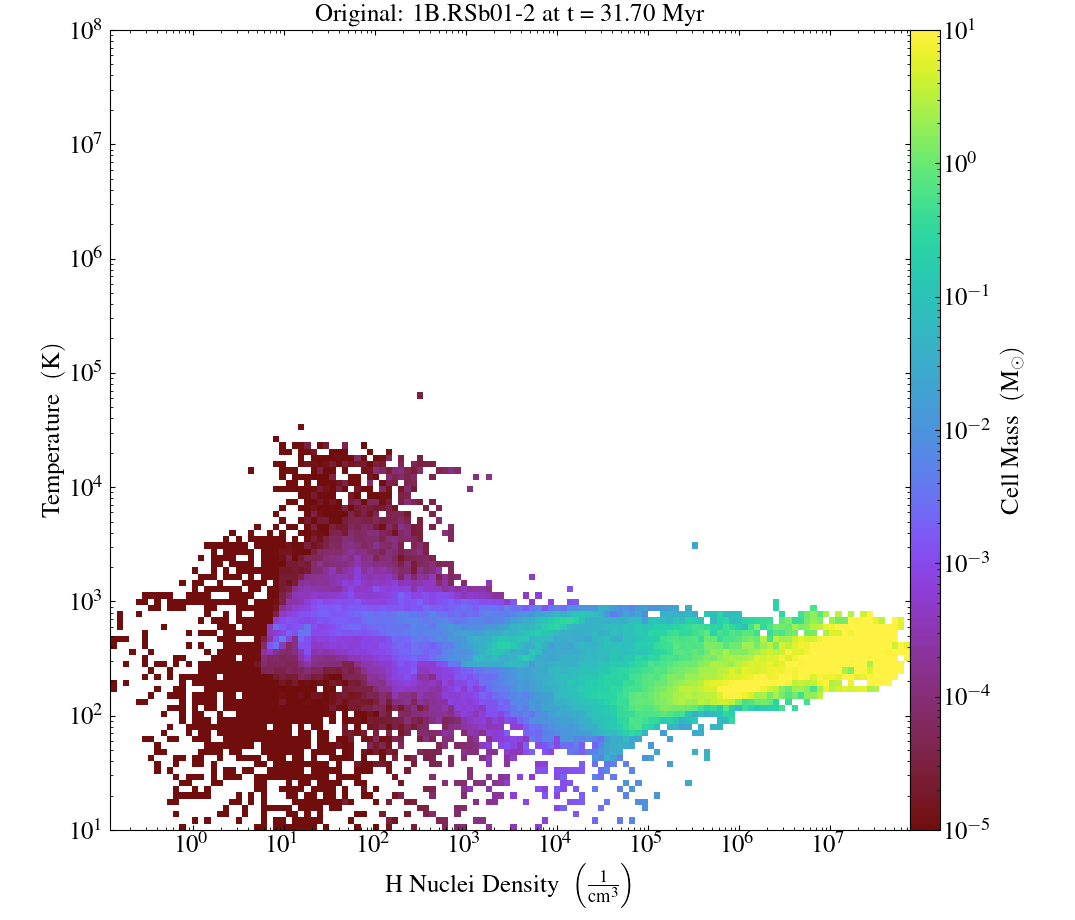


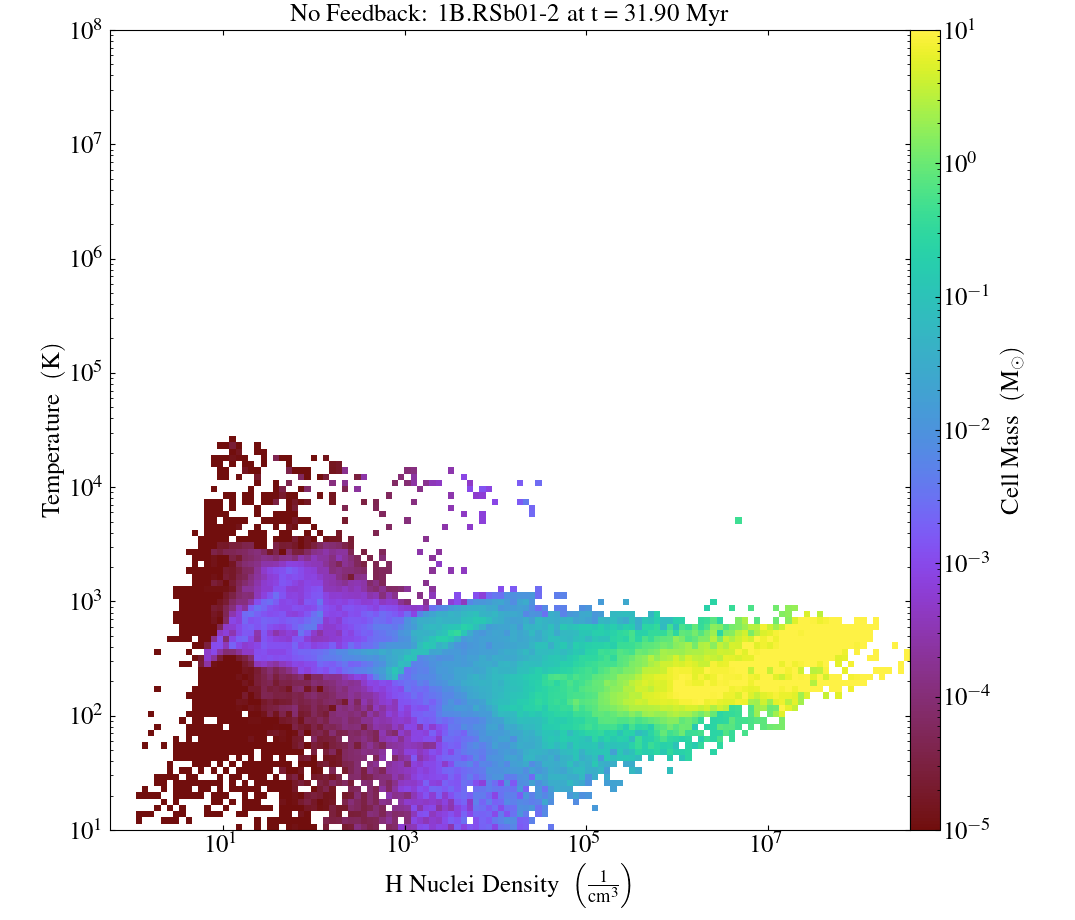


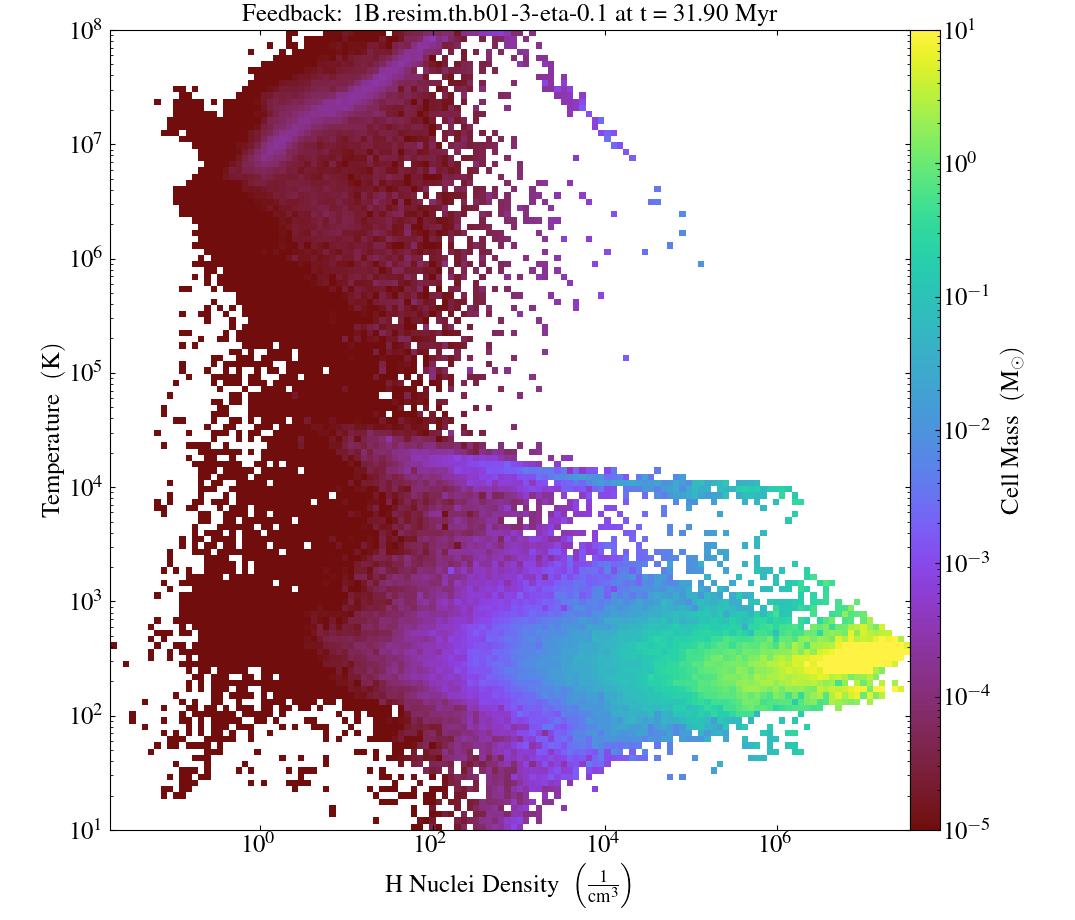

In [84]:

# Define regions around the black hole (assuming ss_pos_no_fb is the position of the BH)
region_radius = (0.5, 'pc')
region_no_feedback = ds_no_feedback.sphere(ss_pos_no_fb, region_radius)
region_with_feedback = ds_with_feedback.sphere(ss_pos_fb, region_radius)
region_og = ds_og.sphere(ss_pos_og, region_radius)

# # Create phase plot for og dataset
plot_og = yt.PhasePlot(region_og, ("gas", "H_nuclei_density"), ("gas", "temperature"), ("gas", "cell_mass"),
                                  weight_field=None, x_bins=128, y_bins=128)

# Create phase plot for no-feedback dataset
plot_no_feedback = yt.PhasePlot(region_no_feedback, ("gas", "H_nuclei_density"), ("gas", "temperature"), ("gas", "cell_mass"),
                                weight_field=None, x_bins=128, y_bins=128)

# # Create phase plot for with-feedback dataset
plot_with_feedback = yt.PhasePlot(region_with_feedback, ("gas", "H_nuclei_density"), ("gas", "temperature"), ("gas", "cell_mass"),
                                  weight_field=None, x_bins=128, y_bins=128)

# colormap
for plot in [plot_og, plot_no_feedback, plot_with_feedback]:
    #plot.set_cmap("cell_mass", "viridis")
    #plot.set_log("cell_mass", False)
    plot.set_unit("cell_mass", "Msun")
    plot.set_zlim("cell_mass", 1e-5, 1e1)
    #plot.set_xlim(1e-25, 1e-16)
    plot.set_ylim(1e1, 1e8)
    t = f"within radius = {region_radius[0]:.2f} pc"
    plot.annotate_text(xpos=1e-19, ypos=3e7, text=t)
    
plot_og.annotate_title(f"Original: {sim_og} at t = {ss_age_og[0]/1e6:.2f} Myr")
plot_no_feedback.annotate_title(f"No Feedback: {sim_no_fb} at t = {ss_age[0]/1e6:.2f} Myr")
plot_with_feedback.annotate_title(f"Feedback: {sim_with_fb} at t = {ss_age_fb[0]/1e6:.2f} Myr")
#plot_no_feedback.set_figure_size((4,5))

# show the plots
plot_og.show()  
plot_no_feedback.show()
plot_with_feedback.show()


- Within 0.2 Myr, strong feedback has affected the temperature and density of the gas. There is now very hot gas - 10^8 K at densities < 10^5 cm^-3, whereas the no-fb run doesn't exceed 10^4 K.

In [82]:
ds_no_feedback.fields

# Tree Plot of Clumps

In [ ]:
from fragplot import TreePlot

CLUMP_FILE_NAME = "'../DD0446_clump_0.h5"
TREE_NAME = "clump_tree_no_fb_446_test.png"

def my_node(clump):
    """
    Customise the appearance of the nodes in the tree plot
    """
    child_clumps = clump.children
    if (child_clumps is None):
        label = ''
    else :
        density = clump[('clump', 'min_number_density')].to('cm**(-3)').value
        label = f'{density:.3g}'

    if (clump[('clump', 'fragmentation_instability')] > 1.0):
        shape = 'square'
    else :
        shape = 'circle'
    my_kwargs = {'label': label, 'fontsize': 16, 'shape': shape}
    return my_kwargs

def create_tree_plot(ds):
    """
    Create a tree plot of the clump hierarchy
    """
    p = TreePlot(ds, dot_kwargs={'rankdir': 'TB', 'size': 18}, node_function= my_node)
    p.size_field = "mass"
    p.color_field = "max_metallicity"
    p.node_cmap = 'turbo'
    p.save(TREE_NAME)


In [ ]:
ds = yt.load(CLUMP_FILE_NAME)
create_tree_plot(df)

In [ ]:
def get_backtest_data(self, all_dates, backtest_start_date, backtest_end_date):
    """
    Creates backtest_X, backtest_Y arrays for backtesting
    """
    
    

In [ ]:
def plot_backtest_results(self):
    if self.bt_type == "average_fee_change":
        agg_func = lambda x: np.nanmean(x[x != 0])
    else:
        agg_func = lambda x: np.nansum(x)
    pnls = np.zeros_like(self.thresholds)
    for i, thr in enumerate(self.thresholds):
        this_pred = (self.prob_Y > thr).astype(int)
        Backtester.run(self, this_pred, self.true_Y)
        pnls[i] = agg_func(self.pnls)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.scatter(self.thresholds, pnls, s=4, color="tomato")
    ax1.set_xlabel("Threshold")
    ax1.set_ylabel(self.bt_type)
    ax1.set_title(f"{self.bt_type} vs. Threshold")
    ax1.grid(True)
    ax1.axhline(0, color="gray", linestyle="--")
    ax2.hist(self.pnls[self.pnls != 0], bins=50, color="tomato", label=self.bt_type)
    ax2.set_xlabel("PnL")
    ax2.set_ylabel(self.bt_type)
    ax2.set_title(f"{self.bt_type} Distribution")
    fig.suptitle(f"Scatter plot, {self.bt_type} vs. Threshold with Histogram")